# Bibliotecas


In [ ]:
import logging
from google.colab import drive
import os
# logging.getLogger('googleapicliet.discovery_cache').setLevel(logging.ERROR)
import ee
ee.Authenticate()
# !earthengine authenticate


#!pip3 install TFRecorder #https://github.com/google/tensorflow-recorder
#!pip3 install graphviz
#!pip3 install h5py

In [ ]:
ee.Initialize()

In [1]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

# GPU config

In [ ]:
import os
import tensorflow as tf

print(tf.__version__)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# Folium setup.
import folium
print(folium.__version__)

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

# ENV Configs

In [5]:
# General 
VERSION = '1'#'10'; #8 é a melhor, 9 é cagada
# MOSAIC_VERSION = '4'
BUCKET = 'mineracao_br'
# GDRIVE = 'mb7-unet-mining-brazil'
FOLDER = 'training_samples_water'
TRAINING_BASE = 'training_patches_water'
# EVAL_BASE = 'eval_patches_' + MOSAIC_VERSION
# SAMPLE_TYPE = ''
# MOSAIC_SCALE = 10
""" PARAMETROS """
# tamanho do pixel de amostragem
PIXEL_SIZE = 10
# Should reproject image to the pixel size? Use it if the input bands have different resolutions
REPROJECT_IMAGE = True
# tamanho do chirp a ser amostrado
CHIRP_SIZE = 256
#CHIRP_SIZE = 64 #rodadas 2 e 3
# bandas de amostragem
EXPORT_BANDS = ['B2','B3','B4','B8','gv','soil','shade']
#EXPORT_BANDS = ['B2','B3','B4','B8','B12','B2_N','B3_N','B4_N','B8_N','B12_N','NDVI','NDVI_N'] #rodadas 2 e 3

# EXPORTING OPTIONS
export_to_tiff = False 
export_path = '/content/drive/MyDrive/training_samples_water'
export_folder= ''

#Local paths
LOCAL_PATH = '/storage/modelos/mb7-unet-fire'
MODEL_DIR = LOCAL_PATH + '/checkpoint/v' + VERSION
OUTPUT_PATH =  LOCAL_PATH + '/output/v' + VERSION
# Exportation Configs
BUCKET_patch = BUCKET
FOLDER_patch = 'allPatch'
FOLDER_classification = 'mb7_mining_'+VERSION

# Specify inputs (Landsat bands) to the model and the response variable.
BANDS = ['blue','green', 'red', 'nir','gv','soil','shade'] # , 'mirbi'
RESPONSE = 'class'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 0
EVAL_SIZE = 0

# Specify model training parameters.
BATCH_SIZE = 12
DROPOUT = 0.3 #0.5
EPOCHS = 50
BUFFER_SIZE = 1000
OPTIMIZER = 'Nadam' 
LOSS = 'BinaryCrossentropy'
# METRICS = ['accuracy','binary_accuracy','RootMeanSquaredError','Hinge']
METRICS = ['accuracy','RootMeanSquaredError','Hinge']

# Data Visualization

In [ ]:
# https://code.earthengine.google.com/6688a949d8ec0e20853605a1f859af36
def calculate_indexs(image):
    bandas = ['blue','green', 'red', 'nir', 'swir1','swir2']
    bandMosaic = ['blue_median_dry','green_median_dry','red_median_dry','nir_median_dry','swir1_median_dry','swir2_median_dry']
    bandsFraction = ['gv','npv','soil','cloud','shade']
    
    endmembers =  [
        [ 119.0,  475.0,  169.0, 6250.0, 2399.0,  675.0], #/*gv*/
        [1514.0, 1597.0, 1421.0, 3053.0, 7707.0, 1975.0], #/*npv*/
        [1799.0, 2479.0, 3158.0, 5437.0, 7707.0, 6646.0], #/*soil*/
        [4031.0, 8714.0, 7900.0, 8989.0, 7002.0, 6607.0], #/*cloud*/
        [   0.0,    0.0,    0.0,    0.0,    0.0,    0.0]  #/*Shade*/
    ]


    fractions = ee.Image(image).select(bandMosaic, bandas)\
                    .unmix(endmembers= endmembers).float()
    
    fractions = fractions.select([0,1,2,3,4], bandsFraction) 
        
    mosaic = image.select(bandMosaic, bandas).divide(10000).multiply(255).toByte()
    return mosaic.addBands(fractions.select(['gv','soil','shade']).multiply(255).toByte())


In [ ]:
param = {
    "asset_mosaic": 'projects/nexgenmap/MapBiomas2/SENTINEL/mosaics-3',
    "asset_region": 'users/geomapeamentoipam/AUXILIAR/regioes_biomas',    
    "asset_output": 'projects/mapbiomas-workspace/AMOSTRAS/ROISs/fireV2/',
    'asset_polygon': 'users/data_sets_solkan/shp_water/group_polygon_water_caat',
    "asset_water": 'projects/mapbiomas-workspace/public/collection7/mapbiomas_collection70_integration_v2',
    "bandas": ['blue_median_dry','green_median_dry','red_median_dry','nir_median_dry','swir1_median_dry','swir2_median_dry'],
    "newbandas": ['blue','green','red','nir','swir1','swir2'],
    "bandas_exp": ['red','nir', 'swir1','swir2'],
    'bioma': ['CAATINGA', 'CERRADO', 'MATAATLANTICA']    
}


In [ ]:

imgCol_mosaic = ee.ImageCollection(param['asset_mosaic']).filter(
                ee.Filter.eq('version', '3')).filter(
                    ee.Filter.inList('biome', param['bioma']))
imgmask = ee.Image(param['asset_water'])
featPolygon = ee.FeatureCollection(param['asset_polygon'])

print("numero de polygons =  ", featPolygon.size().getInfo())


In [ ]:
print("bandas ", imgCol_mosaic.first().bandNames().getInfo())

# dividir os polygons em treino e teste

In [ ]:

featuresPolygonsTrain = ee.FeatureCollection([])
featuresPolygonsTest = ee.FeatureCollection([])

print("size of feature ", featPolygon.size().getInfo())
featPolygon = featPolygon.randomColumn('corte')
featuresPolygonsTrain = featPolygon.filter(ee.Filter.lt('corte', 0.75))
featuresPolygonsTest = featPolygon.filter(ee.Filter.gte('corte', 0.75))

print("tamanho dos polygons  de coletas de fire and not fires TRAIN DATASET", featuresPolygonsTrain.size().getInfo())
print("tamanho dos polygons  de coletas de fire and not fires EVALUATE DATASET", featuresPolygonsTest.size().getInfo())


In [ ]:
def return_array_frommosaic(imgCol, layer_label):
    
    featureStack = ee.Image.cat([
      imgCol.select(BANDS).unmask(0),
      layer_label.rename(RESPONSE).unmask(0)
    ]).float()

    list = ee.List.repeat(1, KERNEL_SIZE)
    lists = ee.List.repeat(list, KERNEL_SIZE)
    kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

    arrays = featureStack.neighborhoodToArray(kernel)

    return arrays


# Train/Test Chips Exportation

In [ ]:

trainingPolysList = featuresPolygonsTrain.toList(featuresPolygonsTrain.size())
evalPolysList = featuresPolygonsTest.toList(featuresPolygonsTest.size())


numero_pol_train = trainingPolysList.size().getInfo()
numero_pol_test = evalPolysList.size().getInfo()
print("lista de Poygons training ", numero_pol_train)
print("lista de Poygons evaluate ", numero_pol_test)

n = 10 # Number of shards in each polygon.
N = 120 # Total sample size in each polygon.

TRAIN_SIZE = numero_pol_train * N
EVAL_SIZE = numero_pol_test * N
print('TRAIN:' + str(TRAIN_SIZE))
print('EVAL:' + str(EVAL_SIZE))



## **Export dataset in tfrecord**

In [ ]:
# Export all the training data (in many pieces), with one task 
# per geometry.
countTrain = 0
countTest = 0
for year in range(2016,2022):
    mosaicYear = imgCol_mosaic.filter(ee.Filter.eq('year', year))
    print("numero de imagens do mosaic = ", mosaicYear.size().getInfo())
    mosaicYear = mosaicYear.map(lambda img: calculate_indexs(img))
    mosaicYear = mosaicYear.mosaic()
    print("bandas do mosaic verificar = ", mosaicYear.bandNames().getInfo())
    water_year = imgmask.select('classification_' + str(year)).eq(33)

    array_mosaic = return_array_frommosaic(mosaicYear, water_year)
    
    for gtr in range(numero_pol_train):        
        geomSample = ee.FeatureCollection([])

        for i in range(n):    
            sample = array_mosaic.sample(
                    region = ee.Feature(trainingPolysList.get(gtr)).geometry(), 
                    scale = 10, 
                    numPixels = N / n, # Size of the shard.
                    seed = i,
                    tileScale = 8
                  )
            geomSample = geomSample.merge(sample)

        print("Exporting {} point features ".format(geomSample.size().getInfo()))
        desc =   "trainWater_YY_" + str(year) + '_g' + str(gtr + countTrain)
        task = ee.batch.Export.table.toDrive(
                          collection = geomSample,
                          description = desc, 
                          folder = FOLDER, 
                          fileNamePrefix = desc,
                          fileFormat = 'TFRecord',
                          selectors = BANDS + [RESPONSE]
                        )
        task.start()

    # Export all the evaluation data.
    for gte in range(numero_pol_test):
        geomSample = ee.FeatureCollection([])
        for i in range(n):
            sample = array_mosaic.sample(
                          region = ee.Feature(evalPolysList.get(gte)).geometry(), 
                          scale = 10, 
                          numPixels = N / n,
                          seed = i,
                          tileScale = 8
                      )
            geomSample = geomSample.merge(sample)

        print("Exporting {} point features ".format(geomSample.size().getInfo()))
        desc =   "testWater_YY_" + str(year) + '_g' + str(gte + countTest)
        task = ee.batch.Export.table.toDrive(
            collection = geomSample,
            description = desc, 
            folder = FOLDER, 
            fileNamePrefix = desc,
            fileFormat = 'TFRecord',
            selectors = BANDS + [RESPONSE],
        )
        task.start()



In [6]:
import numpy as np
def parse_tfrecord(example_proto):
  print(FEATURES_DICT)
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  # my_label = 1
  inputsList = []
  tmp = None
  for cc, kkey in enumerate(FEATURES):
      if cc < len(BANDS):
        tmp = inputs.get(kkey) / 255
      else:
        tmp = inputs.get(kkey)   
      inputsList.append(tmp)
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  print("tamanho matriz ", stacked.shape)
  
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]

def to_single_tensor(inputs):
  # my_label = 1
  inputsList = []
  tmp = None
  for cc, kkey in enumerate(FEATURES):
      if cc < len(BANDS):
        tmp = inputs.get(kkey) / 255
      else:
        tmp = inputs.get(kkey)   
      inputsList.append(tmp)
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  print("tamanho matriz ", stacked.shape)
  
  return stacked[:,:,:len(BANDS)]


def get_dataset(pattern, prediction=False):
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

In [7]:
def get_training_dataset():
	glob = '/content/drive/MyDrive/training_samples_water/trainWater_YY_*'
	print(glob)

	dataset = get_dataset(glob)
	dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
	return dataset

training = get_training_dataset()
print(training.take(1))

/content/drive/MyDrive/training_samples_water/trainWater_YY_*
{'blue': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'green': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'red': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'nir': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'gv': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'soil': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'shade': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'class': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None)}
tamanho matriz  (256, 256, 8)
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


In [8]:
def get_eval_dataset():
	glob = '/content/drive/MyDrive/training_samples_water/testWater_YY_*' 
	dataset = get_dataset(glob)
	dataset = dataset.batch(3)
	return dataset

evaluation = get_eval_dataset()
print(evaluation.take(1))

{'blue': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'green': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'red': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'nir': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'gv': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'soil': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'shade': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'class': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None)}
tamanho matriz  (256, 256, 8)
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


In [23]:
def get_prediction_dataset():
	glob = '/content/drive/MyDrive/pred_samples_water/trainWater_YY_*' 
	dataset = get_dataset(glob, True)
	dataset = dataset.batch(15)
	return dataset

prediction_dataset = get_prediction_dataset()
print(prediction_dataset.take(1))

{'blue': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'green': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'red': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'nir': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'gv': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'soil': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'shade': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None), 'class': FixedLenFeature(shape=[256, 256], dtype=tf.float32, default_value=None)}
tamanho matriz  (256, 256, 8)
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


# UNET

In [9]:
from keras.optimizers.optimizer_v2.nadam import Nadam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    conv_output = Conv2D(num_filters, (3, 3), padding='same')(input)
    conv_output = BatchNormalization()(conv_output)
    conv_output = Activation('relu')(conv_output)

    conv_output = Conv2D(num_filters, (3, 3), padding='same')(conv_output)
    conv_output = BatchNormalization()(conv_output)
    conv_output = Activation('relu')(conv_output)

    return conv_output

def encoder_block(input, num_filters):
    conv_output = conv_block(input, num_filters)
    pooling_output = MaxPooling2D((2,2), strides=(2, 2))(conv_output)

    return conv_output, pooling_output

def decoder_block(input_tensor, skip_features, num_filters):
    transposed = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input_tensor)
    concat_result = Concatenate()([transposed, skip_features])
    conv_output = conv_block(concat_result, num_filters)
    return conv_output

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    final_layer = Conv2D(num_classes, (1,1), padding='same', activation='sigmoid')
    outputs = final_layer(d4)

    model = Model(inputs, outputs, name='U-Net')
    return model

def get_model():
    my_model = build_unet(input_shape=(256,256,7), num_classes=1)
    print(my_model.summary())
    my_model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy','RootMeanSquaredError','BinaryAccuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return my_model

model = get_model()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 7  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  4096        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Model Selection/Load

In [15]:
import matplotlib.pyplot as plt
import math
import datetime, os

plt.style.use("ggplot")
checkpoint_path = "/content/drive/MyDrive/checkpoint/v1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

n = 20 # Number of shards in each polygon.
N = 200 # Total sample size in each polygon.
TRAIN_SIZE = 80 * N
EVAL_SIZE = 20 * N

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='output/v'+VERSION+'/log_model',write_images=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                                  filepath= checkpoint_path,
                                  monitor= 'accuracy',
                                  verbose= 1, 
                                  save_weights_only=True, 
                                  save_freq=2
                                )
callbacksfun = [cp_callback,tensorboard]

result = model.fit(
          x= training,
          epochs= 20,
          # initial_epoch= 0, # REMEBER TO CHANGE THIS INITIAL EPOCH PARAM, WHEN OTHER MODEL HAS BEEN LOADED
          steps_per_epoch= 300, #int(TRAIN_SIZE / BATCH_SIZE), 
          verbose= 1,
          shuffle= True,
          validation_data= evaluation,
          # callbacks = callbacksfun
        )


Epoch 1/20
300/300 [==============================] - 188s 597ms/step - loss: 0.0447 - accuracy: 0.9827 - root_mean_squared_error: 0.1126 - binary_accuracy: 0.9827 - precision: 0.9238 - recall: 0.9227 - val_loss: 0.0442 - val_accuracy: 0.9806 - val_root_mean_squared_error: 0.1146 - val_binary_accuracy: 0.9806 - val_precision: 0.8359 - val_recall: 0.9649
Epoch 2/20
300/300 [==============================] - 179s 599ms/step - loss: 0.0616 - accuracy: 0.9799 - root_mean_squared_error: 0.1263 - binary_accuracy: 0.9799 - precision: 0.9441 - recall: 0.8782 - val_loss: 0.1000 - val_accuracy: 0.9733 - val_root_mean_squared_error: 0.1494 - val_binary_accuracy: 0.9733 - val_precision: 0.7732 - val_recall: 0.9795
Epoch 3/20
300/300 [==============================] - 180s 600ms/step - loss: 0.0374 - accuracy: 0.9882 - root_mean_squared_error: 0.0967 - binary_accuracy: 0.9882 - precision: 0.9320 - recall: 0.8622 - val_loss: 0.0524 - val_accuracy: 0.9821 - val_root_mean_squared_error: 0.1157 - val_b

300/300 [==============================] - 147s 490ms/step - loss: 0.0237 - accuracy: 0.9905 - root_mean_squared_error: 0.0835 - binary_accuracy: 0.9905 - precision: 0.9044 - recall: 0.9129 - val_loss: 0.0426 - val_accuracy: 0.9829 - val_root_mean_squared_error: 0.1103 - val_binary_accuracy: 0.9829 - val_precision: 0.8818 - val_recall: 0.9269


In [10]:
modelPath = '/content/drive/MyDrive/model'
# model.save(
#     modelPath
# )
model = tf.keras.models.load_model(modelPath)


In [111]:
single_record = iter(prediction_dataset.shuffle(100).take(1)).next()
image_list = single_record[0]
mask_list = single_record[1]
print("Image matrix dimensions ", image_list.shape)
print("Mask matrix dimensions ", mask_list.shape)

Image matrix dimensions  (15, 256, 256, 7)
Mask matrix dimensions  (15, 256, 256, 1)


In [108]:
predicted_mask = model.predict(image_list)
print(predicted_mask[1, :, :, 0])

1/1 [==============================] - 0s 34ms/step
[[9.0504837e-01 9.4810206e-01 9.6616590e-01 ... 5.5764365e-01
  4.6654111e-01 1.2390286e-01]
 [9.4848520e-01 9.7494841e-01 9.7404003e-01 ... 6.1051518e-01
  5.2777427e-01 3.4624439e-01]
 [9.5718932e-01 9.7028637e-01 9.7679967e-01 ... 5.6020874e-01
  5.3182775e-01 3.8703039e-01]
 ...
 [1.5183144e-03 3.1205363e-04 2.1950377e-04 ... 2.4054539e-04
  3.1321874e-04 1.3598891e-03]
 [1.5205700e-03 3.2447794e-04 2.4677199e-04 ... 3.1750786e-04
  4.1782728e-04 1.6104998e-03]
 [1.9499674e-03 1.0692502e-03 7.7089650e-04 ... 9.4308367e-04
  1.2245260e-03 2.9997702e-03]]


In [109]:
n_classes = 2
predicted_mask_tresholded = predicted_mask > 0.5
IOU_keras = tf.keras.metrics.MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(predicted_mask_tresholded, mask_list)
print("Mean IoU =", IOU_keras.result().numpy())
precision = tf.keras.metrics.Precision()  
precision.update_state(mask_list, predicted_mask)
print("Precision =", precision.result().numpy())
recall = tf.keras.metrics.Recall()  
recall.update_state(mask_list, predicted_mask)
print("Recall =", recall.result().numpy())

Mean IoU = 0.9703121
Precision = 0.9778739
Recall = 0.9773253


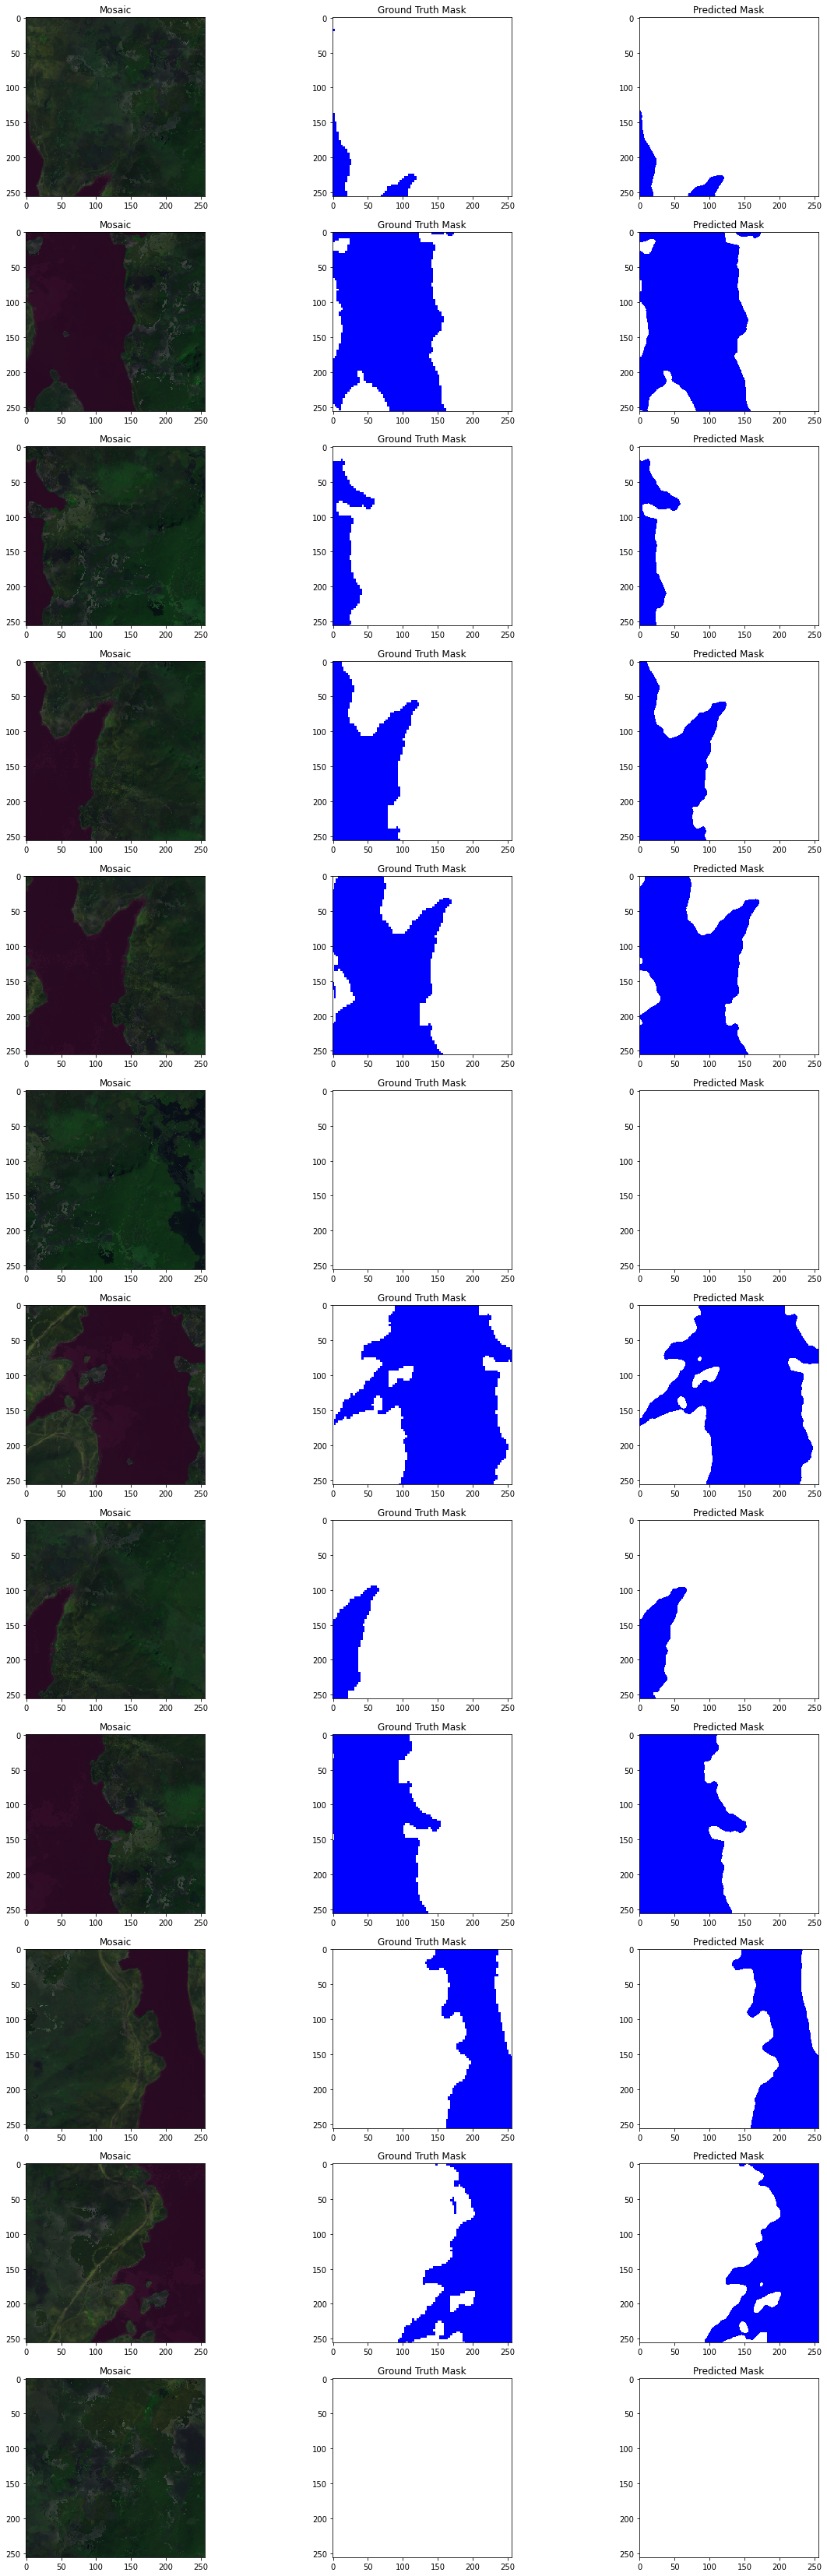

In [110]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def drawContour(segm):
    """Draw edges of contour 'c' from segmented image 's' onto 'm' in colour 'RGB'"""
    # Fill contour "c" with white, make all else black
    thisContour = segm * 255
    thisContour = 255 - thisContour
    imgSeg = np.stack([thisContour,thisContour,np.ones(segm.shape)])
    imgSeg = np.transpose(imgSeg,[2, 1, 0])
    
    return imgSeg


fig, ax = plt.subplots(figsize=[20,60], nrows=12, ncols=3)

for ii in range(12):
    bnd_red = image_list[ii, :, : , 0].numpy()
    bnd_nir = image_list[ii, :, : , 3].numpy()
    bnd_swir1 = image_list[ii, :, : , 2].numpy()
    imgRGB = np.stack([bnd_swir1,bnd_nir,bnd_red])
    imgRGB = np.transpose(imgRGB,[2, 1, 0])
    mask = mask_list[ii, :, :, 0].numpy()
    predicted_img = (predicted_mask[ii, :, :, 0] > 0.5)

    blueMask = drawContour(mask)
    bluePred = drawContour(predicted_img)

    # show original image
    ax[ii, 0].set_title('Mosaic', fontsize = 12)
    ax[ii, 0].imshow(imgRGB, interpolation='nearest', vmin=0, vmax=50)
    ax[ii, 1].set_title('Ground Truth Mask', fontsize = 12)
    ax[ii, 1].imshow(blueMask, interpolation='nearest',vmin=0, vmax=50)
    ax[ii, 2].set_title('Predicted Mask', fontsize = 12)
    ax[ii, 2].imshow(bluePred, interpolation='nearest',vmin=0, vmax=50)

plt.show() 

In [ ]:
import numpy 
%matplotlib inline
print(result.history)
plt.figure(figsize=(8, 8))
plt.title("RMSE curve")
plt.plot(result.history["root_mean_squared_error"], label="RMSE")
# plt.plot(result.history["root_mean_squared_error"], label="val_loss")
# plt.plot( numpy.argmax(result.history["root_mean_squared_error"]), numpy.max(result.history["root_mean_squared_error"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("root_mean_squared_error")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("accuracy curve")
plt.plot(result.history["accuracy"], label="accuracy")
# plt.plot(result.history["accuracy"], label="accuracy")
# plt.plot( numpy.argmin(result.history["accuracy"]), numpy.min(result.history["accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();